In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!pip install tensorflow-hub
!pip install numpy==1.16.1
!pip install keras==2.2.4
!pip uninstall -qy git+https://github.com/LanceNorskog/deep_meter_2#egg=deepmeter
!pip install -q git+https://github.com/LanceNorskog/deep_meter_2#egg=deepmeter
!wget -nc https://raw.githubusercontent.com/LanceNorskog/deep_meter_2/master/haiku_5.txt
!cut -f2 < haiku_5.txt | sort | uniq > haiku_5_short.txt
!wc -l haiku_5*.txt

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
File ‘haiku_5.txt’ already there; not retrieving.

   95631 haiku_5_short.txt
  673680 haiku_5.txt
  769311 total


In [0]:
#!rm /content/model_haiku_5*

In [3]:

from __future__ import print_function
import math
import pickle
import json
import os
import glob
import time

import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import keras.backend as K
import matplotlib.pyplot as plt

from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model, Sequential, load_model
from keras import layers 
from keras import metrics
from keras.datasets import reuters
from keras.preprocessing import text
from sklearn.model_selection import train_test_split

from cmu.syllables_cmu import syllables as word2sylls
from cmu.mappers import Decoder
from search.full import FullSearch
from cmu.topk import topk as get_top_k
print(word2sylls['therefore'])

# number of total samples to use
max_data = 100000
# cut texts after this number of words
# number of output syllables in short haiku
max_features = 35000
# longest output sentence
maxlen = 5
batch_size = 32
deduplicate_haiku=True
model_base="/content/gdrive/My Drive/Colab Notebooks/haiku_5_"
model_base="/content/model_haiku_5_"
model_base="/content/gdrive/My Drive/Colab Notebooks/haiku_5_"
model_file=model_base + ".h5".format(int(time.time()))
print(model_file)


Using TensorFlow backend.


['DH EH R', 'F AO R']
/content/gdrive/My Drive/Colab Notebooks/haiku_5_.h5


In [4]:
!date
decoder = Decoder(word2sylls)
syll2idx = decoder.syll2idx
idx2syll = decoder.idx2syll
num_sylls = len(idx2syll)

print(syll2idx['DH EH R'], idx2syll[1])
print('# features: ', len(idx2syll))


Tue Jul  9 03:44:59 UTC 2019
['!exclamation-point', '"close-quote', '"double-quote', '"end-of-quote', '"end-quote', '"in-quotes', '"quote', '"unquote', '%percent', '&ampersand']
['AA', 'AA B', 'AA B S T', 'AA CH', 'AA D', 'AA D Z', 'AA F', 'AA F S', 'AA F S K', 'AA G']
19433 0
# features:  32088


In [5]:
big_text = []
big_haiku = []
big_data = []
big_data_file = "haiku_5.txt"
with open(big_data_file) as f:
    last_haiku = ''
    for line in f.readlines():
        _parts = line.strip().split('\t')
        _text = _parts[0]
        _haiku = _parts[1]
        _sylls = []
        if deduplicate_haiku and _haiku == last_haiku:
            continue
        for word in text.text_to_word_sequence(_haiku):
            if word in word2sylls:
                for syll in word2sylls[word]:
                    _sylls.append(syll)
        if len(_sylls) != 5:
            continue
        _data = np.zeros((5), dtype='int32')
        for j in range(5):
             _data[j] = syll2idx[_sylls[j]]
        big_text.append(_text)
        big_haiku.append(_haiku)
        big_data.append(_data)
        #if len(big_text) == max_data * 2:
        #    break

big_text = np.array(big_text)
big_haiku = np.array(big_haiku)
big_data = np.array(big_data)
big_data = np.expand_dims(big_data, -1)
print('{} -> {} : {}'.format(big_text[0], big_haiku[0], big_data[0]))

shuffle = np.arange(len(big_text))
print(shuffle)
np.random.shuffle(shuffle)
shuffle = shuffle[0:max_data]
big_text = big_text[shuffle]
big_haiku = big_haiku[shuffle]
big_data = big_data[shuffle]
print('{} -> {} : {}'.format(big_text[0], big_haiku[0], big_data[0]))

print('Full length clauses: ', len(big_text))

a white sink and door -> a white sink and door : [[17146]
 [31228]
 [27105]
 [17115]
 [18834]]
[     0      1      2 ... 668545 668546 668547]
a remote control has all black and white buttons except for a yellow light " button -> a remote control : [[17146]
 [26501]
 [24697]
 [22523]
 [30217]]
Full length clauses:  100000


In [0]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]
embed = hub.Module(module_url)
embed_size = embed.get_output_info_dict()['default'].get_shape()[1].value
def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

In [7]:
(x_train, x_test, y_train, y_test) = train_test_split(big_text, big_data)
x_train = x_train[0:(len(x_train) // batch_size) * batch_size]
y_train = y_train[0:(len(y_train) // batch_size) * batch_size]
x_test = x_test[0:(len(x_test) // batch_size) * batch_size]
y_test = y_test[0:(len(y_test) // batch_size) * batch_size]

print('{} -> {}'.format(big_text[0], [idx2syll[big_data[0][x][0]] for x in range(len(big_data[0]))]))
print(x_test[0], y_test[0])

def get_lstm(size, return_sequences=True):
    return layers.CuDNNLSTM(size, return_sequences=return_sequences)

#x_train = np.array(x_train)
#x_test = np.array(x_test)
#y_train = np.expand_dims(y_train, -1)
#y_test = np.expand_dims(y_test, -1)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print(y_test[0][0])



a remote control has all black and white buttons except for a yellow light " button -> ['AH', 'R IH', 'M OW T', 'K AH N', 'T R OW L']
a dirt walking path [[17146]
 [18972]
 [31128]
 [22768]
 [25454]]
x_train shape: (74976,)
x_test shape: (24992,)
y_train shape: (74976, 5, 1)
y_test shape: (24992, 5, 1)
[17146]


In [0]:
# https://github.com/philipperemy/keras-snail-attention/blob/master/attention.py
# Do these Dense layers need activation tanh?
# https://www.d2l.ai/chapter_attention-mechanism/attention.html
# k, q have attention, v does not?
class AttentionBlock(layers.Layer):

    def __init__(self, dims, k_size, v_size, seq_len=None, **kwargs):
        self.k_size = k_size
        self.seq_len = seq_len
        self.v_size = v_size
        self.dims = dims
        self.sqrt_k = math.sqrt(k_size)
        self.keys_fc = None
        self.queries_fc = None
        self.values_fc = None
        super(AttentionBlock, self).__init__(**kwargs)

    def build(self, input_shape):
        # https://stackoverflow.com/questions/54194724/how-to-use-keras-layers-in-custom-keras-layer
        self.keys_fc = layers.Dense(self.k_size)
        self.keys_fc.build((None, self.dims))
        self._trainable_weights.extend(self.keys_fc.trainable_weights)

        self.queries_fc = layers.Dense(self.k_size)
        self.queries_fc.build((None, self.dims))
        self._trainable_weights.extend(self.queries_fc.trainable_weights)

        self.values_fc = layers.Dense(self.v_size)
        self.values_fc.build((None, self.dims))
        self._trainable_weights.extend(self.values_fc.trainable_weights)

    def call(self, inputs, **kwargs):
        # check that the implementation matches exactly py torch.
        keys = self.keys_fc(inputs)
        queries = self.queries_fc(inputs)
        values = self.values_fc(inputs)
        logits = K.batch_dot(queries, K.permute_dimensions(keys, (0, 2, 1)))
        mask = K.ones_like(logits) * np.triu((-np.inf) * np.ones(logits.shape.as_list()[1:]), k=1)
        logits = mask + logits
        probs = layers.Softmax(axis=-1)(logits / self.sqrt_k)
        read = K.batch_dot(probs, values)
        output = K.concatenate([inputs, read], axis=-1)
        return output

    def compute_output_shape(self, input_shape):
        output_shape = list(input_shape)
        output_shape[-1] += self.v_size
        return tuple(output_shape)



In [9]:
def sparse_categorical_accuracy(y_true, y_pred):
    # reshape in case it's in shape (num_samples, 1) instead of (num_samples,)
    if K.ndim(y_true) == K.ndim(y_pred):
        y_true = K.squeeze(y_true, -1)
    # convert dense predictions to labels
    y_pred_labels = K.argmax(y_pred, axis=-1)
    y_pred_labels = K.cast(y_pred_labels, K.floatx())
    return K.cast(K.equal(y_true, y_pred_labels), K.floatx())

def sparse_categorical_accuracy_per_sequence(y_true, y_pred):
    # reshape in case it's in shape (num_samples, 1) instead of (num_samples,)
    if K.ndim(y_true) == K.ndim(y_pred):
        y_true = K.squeeze(y_true, -1)
    # convert dense predictions to labels
    y_pred_labels = K.argmax(y_pred, axis=-1)
    y_pred_labels = K.cast(y_pred_labels, K.floatx())
    return K.min(K.cast(K.equal(y_true, y_pred_labels), K.floatx()), axis=-1)

def sparse_temporal_top_k_categorical_accuracy(y_true, y_pred, k=5):
    original_shape = K.shape(y_true)
    y_true = K.reshape(y_true, (-1, K.shape(y_true)[-1]))
    y_pred = K.reshape(y_pred, (-1, K.shape(y_pred)[-1]))
    top_k = K.in_top_k(y_pred, K.cast(K.max(y_true, axis=-1), 'int32'), k)
    return K.reshape(top_k, original_shape[:-1])

def sparse_temporal_top_k_categorical_accuracy_per_sequence(y_true, y_pred, k=5):
    original_shape = K.shape(y_true)
    y_true = K.reshape(y_true, (-1, K.shape(y_true)[-1]))
    y_pred = K.reshape(y_pred, (-1, K.shape(y_pred)[-1]))
    top_k = K.in_top_k(y_pred, K.cast(K.max(y_true, axis=-1), 'int32'), k)
    perfect = K.min(K.cast(top_k, 'int32'), axis=-1)
    return perfect #K.expand_dims(perfect, axis=-1)

def sparse(y_true, y_pred):
    return sparse_categorical_accuracy(y_true, y_pred)
def sparse1(y_true, y_pred):
    return sparse_temporal_top_k_categorical_accuracy(y_true, y_pred, k=1)
def perfect(y_true, y_pred):
    return sparse_categorical_accuracy_per_sequence(y_true, y_pred)
def perfect1(y_true, y_pred):
    return sparse_temporal_top_k_categorical_accuracy_per_sequence(y_true, y_pred, k=1)
def sparse5(y_true, y_pred):
    return sparse_temporal_top_k_categorical_accuracy(y_true, y_pred, k=5)
def perfect5(y_true, y_pred):
    return sparse_temporal_top_k_categorical_accuracy_per_sequence(y_true, y_pred, k=5)
def fscore(y_true, y_pred):
    recall = K.mean(sparse_categorical_accuracy(y_true, y_pred))
    precision = K.mean(sparse_categorical_accuracy_per_sequence(y_true, y_pred))
    return 2 * ((recall * precision)/(recall + precision))


units_k=embed_size
units_v=embed_size//3
units=512

metric_list = [sparse, perfect]
metric_names = ['sparse', 'perfect']
# model loading bug
metric_list = []
metric_names = []

input_text = layers.Input(shape=(1,), dtype=tf.string)
x = layers.Lambda(UniversalEmbedding, output_shape=(embed_size,), name='TF-Hub')(input_text)
x = layers.RepeatVector(maxlen)(x)
x = layers.Dropout(0.5)(x)
if False:
    x = AttentionBlock(embed_size, k_size=units_k, v_size=units_v)(x)
x = get_lstm(units, return_sequences=True)(x)
#x = layers.Dropout(0.5)(x)
#x = layers.Dense(units*2, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(max_features, activation='softmax')(x)


model = Model(inputs=[input_text], outputs=output_layer)
model.compile('adam', 'sparse_categorical_crossentropy', metrics=metric_list)
model.summary()

# try using different optimizers and different optimizer configs

print('Train...')
history = None
use_saved_model=False
if not use_saved_model or not os.path.exists(model_file):
  with tf.Session() as session:
    K.manual_variable_initialization(False)
    model_file=model_base + ".h5".format(int(time.time()))
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())

    history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=50,
          callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5),
            ModelCheckpoint(model_file, monitor='val_loss', save_best_only=True, save_weights_only=True, mode='min', verbose=1)],
          verbose=2,
          validation_data=[x_test, y_test])
    model.save_weights(model_file)


W0709 03:45:15.618144 139753104537472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0709 03:45:15.619668 139753104537472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0709 03:45:16.650156 139753104537472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0709 03:45:16.659564 139753104537472 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a futur

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
TF-Hub (Lambda)              (None, 512)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 5, 512)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 512)            0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 5, 512)            2101248   
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 512)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 5, 35000)          17955000  
Total para

W0709 03:45:20.777346 139753104537472 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 74976 samples, validate on 24992 samples
Epoch 1/50
 - 121s - loss: 4.3641 - val_loss: 2.9491

Epoch 00001: val_loss improved from inf to 2.94912, saving model to /content/gdrive/My Drive/Colab Notebooks/haiku_5_.h5
Epoch 2/50
 - 116s - loss: 2.8316 - val_loss: 2.3398

Epoch 00002: val_loss improved from 2.94912 to 2.33982, saving model to /content/gdrive/My Drive/Colab Notebooks/haiku_5_.h5
Epoch 3/50
 - 116s - loss: 2.4331 - val_loss: 2.0836

Epoch 00003: val_loss improved from 2.33982 to 2.08361, saving model to /content/gdrive/My Drive/Colab Notebooks/haiku_5_.h5
Epoch 4/50
 - 116s - loss: 2.2158 - val_loss: 1.9377

Epoch 00004: val_loss improved from 2.08361 to 1.93772, saving model to /content/gdrive/My Drive/Colab Notebooks/haiku_5_.h5
Epoch 5/50
 - 116s - loss: 2.0706 - val_loss: 1.8423

Epoch 00005: val_loss improved from 1.93772 to 1.84229, saving model to /content/gdrive/My Drive/Colab Notebooks/haiku_5_.h5
Epoch 6/50
 - 116s - loss: 1.9643 - val_loss: 1.7701

Epoch

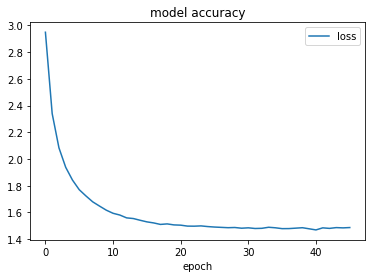

In [10]:

if history != None:
  names = metric_names + ['loss']
  # summarize history for accuracy
  for m in names:
      #plt.plot(history.history[m])
      plt.plot(history.history['val_' + m])
  plt.title('model accuracy')
  plt.xlabel('epoch')
  plt.legend(names, loc='upper right')
  plt.show()

In [0]:
def report(data, prediction):
    def match(data, prediction):
        good = 0
        top5 = 0
        count = 0
        for i in range(len(data)):
            topind = np.argsort(prediction[i])
            if data[i][0] == topind[-1]:
                good += 1
            topind = topind[-5:len(topind)]
            for j in range(5):
                if data[i][0] == topind[j]:
                    top5 += 1
                    break
            count += 1
        return (good, top5, count)

    _sparse = 0.0
    _perfect = 0.0
    _sparse5 = 0.0
    _perfect5 = 0.0
    _total = 0
    for n in range(len(data)):
        #print(len(short[n]))
        (good, top5, count) = match(data[n], predicts[n])
        if count == 0:
            continue
        _sparse += good/count
        _sparse5 += top5/count
        if good == count:
            _perfect += 1  
        if top5 == count:
            _perfect5 += 1
        _total += 1
    return {'sparse':_sparse/_total, 'perfect': _perfect/_total, 'sparse5': _sparse5/_total, 'perfect5': _perfect5/_total}


In [12]:


x_short = big_text[0:500]
y_short = big_data[0:500]
predicts = None

with tf.Session() as session:
    #K.manual_variable_initialization(True)  
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    # need this?
    session.run(tf.tables_initializer())
    #model = load_model(model_file)  
    model.load_weights(model_file)  
    #eval = model.evaluate(x_test, y_test)
    #print('model.evaluate on short: ' ,model.metrics_names, eval)
    predicts = model.predict(x_short, batch_size=32)
    print('shape: {}'.format(predicts.shape))

print(len(predicts[0]))
print(len(predicts[0][0]))
print(predicts[0])

shape: (500, 5, 35000)
5
35000
[[1.33180915e-08 1.32330884e-08 1.32735094e-08 ... 1.34967637e-08
  1.33160079e-08 1.34514044e-08]
 [4.67115058e-09 4.62579175e-09 4.57032145e-09 ... 4.59637262e-09
  4.68835992e-09 4.60506877e-09]
 [1.02781028e-09 9.94346494e-10 1.02036435e-09 ... 1.00451625e-09
  1.00161401e-09 1.01579345e-09]
 [3.50427846e-11 3.45523089e-11 3.48043122e-11 ... 3.51791304e-11
  3.44400619e-11 3.50992430e-11]
 [1.21886834e-10 1.19110569e-10 1.20558521e-10 ... 1.21527011e-10
  1.20202168e-10 1.21144456e-10]]


In [13]:
for i in range(20):
    rep = report([y_short[i]], [predicts[i]])
    print(rep)

{'sparse': 1.0, 'perfect': 1.0, 'sparse5': 1.0, 'perfect5': 1.0}
{'sparse': 0.0, 'perfect': 0.0, 'sparse5': 0.2, 'perfect5': 0.0}
{'sparse': 0.0, 'perfect': 0.0, 'sparse5': 0.0, 'perfect5': 0.0}
{'sparse': 0.0, 'perfect': 0.0, 'sparse5': 0.2, 'perfect5': 0.0}
{'sparse': 0.2, 'perfect': 0.0, 'sparse5': 0.2, 'perfect5': 0.0}
{'sparse': 0.0, 'perfect': 0.0, 'sparse5': 0.0, 'perfect5': 0.0}
{'sparse': 0.0, 'perfect': 0.0, 'sparse5': 0.2, 'perfect5': 0.0}
{'sparse': 0.0, 'perfect': 0.0, 'sparse5': 0.0, 'perfect5': 0.0}
{'sparse': 0.0, 'perfect': 0.0, 'sparse5': 0.2, 'perfect5': 0.0}
{'sparse': 0.0, 'perfect': 0.0, 'sparse5': 0.0, 'perfect5': 0.0}
{'sparse': 0.0, 'perfect': 0.0, 'sparse5': 0.2, 'perfect5': 0.0}
{'sparse': 0.0, 'perfect': 0.0, 'sparse5': 0.0, 'perfect5': 0.0}
{'sparse': 0.0, 'perfect': 0.0, 'sparse5': 0.2, 'perfect5': 0.0}
{'sparse': 0.0, 'perfect': 0.0, 'sparse5': 0.0, 'perfect5': 0.0}
{'sparse': 0.0, 'perfect': 0.0, 'sparse5': 0.0, 'perfect5': 0.0}
{'sparse': 0.0, 'perfect'

In [0]:
top_k=10

(mini_vals, mini_preds) = get_top_k(np.array(predicts), top_k=top_k)
print('top preds: ', mini_preds[0])
print(mini_preds.shape)
total = 0
_go = []
for x in mini_preds[0]:
            _go.append(decoder.idx2syll[x[0]])
print('{} -> {}'.format(x_short[0], str(_go)))
for i in range(len(mini_preds)):
    fs = FullSearch(top_k * top_k * top_k, 5, top_k)
    fs.mainloop(mini_preds[i])
    #print('score[0]: {}'.format(fs.scorevals[0]))
    #print('paths[0]: {}'.format(fs.scorepaths[0]))
    #print('score[-1]: {}'.format(fs.scorevals[-1]))
    #print('paths[-1]: {}'.format(fs.scorepaths[-1]))
    #print('min {}, max {}'.format(np.min(fs.scorevals), np.max(fs.scorevals)))
    encoded = decoder.get_sentences(fs.scorepaths)
    if i == 0:
        print('encoded[0]: ', encoded[0])
    d = []
    for x in encoded[0]:
        for y in x:
            if len(y) > 0:
                d.append(y)   
    if len(d) > 0:
        print(x_short[i], ':')
        print(mini_preds[0])
        total += 1
        decoded = decoder.decode_sentences(d)
        sentences = {}
        for d in decoded:
            key = ' '.join(d)
            sentences[key] = d
        print('[{}]  -> ', i,list(sentences.keys()))
print('Total decoded: {}'.format(total))

top preds:  [[17146 17113 19415 30278 17198 17708 31345 25322 17021 31119]
 [25165 28201 19746 21980 31119 17214 17146 30278 30590 31313]
 [31313 23888 26903 29813 31119 28201 26402 18957 17146 19919]
 [28201 31313 26903 19481 19919 29824 26612 28673 26606 24391]
 [26903 28201 29025 29030 26905 31313 29824 22509 19413 23874]]
(1024, 5, 10)
a remote control has all black and white buttons except for a yellow light " button -> ['AH', 'N OW', 'W EY', 'S T AA P', 'S AY N']
encoded[0]:  []


In [15]:
with tf.Session() as session:
  #K.manual_variable_initialization(True)  
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  #model = load_model(model_file)  
  model.load_weights(model_file)  
  eval_small = model.evaluate(big_haiku, big_data)
  print('model.evaluate on haiku clauses: ' ,model.metrics_names, eval_small)
  print('history: ', history)
  eval_big = model.evaluate(big_text, big_data)
  print('model.evaluate on long clauses: ' ,model.metrics_names, eval_big)
  print('history: ', history)
  biglen = len(big_text)
  #for i in range(0, len(big_text), batch_size):
  #  predicts = model.predict(big_text[i:i + batch_size], batch_size=batch_size)
  #  print('shape: {}'.format(predicts.shape))


   160/100000 [..............................] - ETA: 9:02 

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f1a67fadf60>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


100000/100000 [==============================] - 66s 659us/step
model.evaluate on haiku clauses:  ['loss'] 0.6009694620466233
history:  <keras.callbacks.History object at 0x7f1a68955c18>
100000/100000 [==============================] - 67s 674us/step
model.evaluate on long clauses:  ['loss'] 0.8417476171016693
history:  <keras.callbacks.History object at 0x7f1a68955c18>


In [16]:
metric_list = [sparse, perfect]
metric_names = ['sparse', 'perfect']

model = Model(inputs=[input_text], outputs=output_layer)
model.compile('adam', 'sparse_categorical_crossentropy', metrics=metric_list)

bigbatch = batch_size * 32
big_text = np.array(big_text)
big_haiku = np.array(big_haiku)
text5arr = []
haiku5mean = None
with tf.Session() as session:
  #K.manual_variable_initialization(True)  
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  #model = load_model(model_file)  
  model.load_weights(model_file)  
  predicts = model.predict(big_haiku[0: bigbatch], batch_size=bigbatch)
  rep = report(big_data[0: bigbatch], predicts)
  print("short {}".format(rep))
  haiku5mean = rep['perfect5']
  biglen = len(big_text)
  for i in range(0, biglen, bigbatch):
    predicts = model.predict(big_text[i:i + bigbatch], batch_size=bigbatch)
    rep = report(big_data[i:i + bigbatch], predicts)
    print("[{}] {}".format(i, rep))
    text5arr.append(rep['perfect5'])

text5mean = np.mean(np.array(text5arr))

short {'sparse': 0.867578124999999, 'perfect': 0.662109375, 'sparse5': 0.9503906249999989, 'perfect5': 0.853515625}
[0] {'sparse': 0.8023437499999986, 'perfect': 0.53515625, 'sparse5': 0.9369140624999993, 'perfect5': 0.8056640625}
[1024] {'sparse': 0.8035156249999977, 'perfect': 0.5263671875, 'sparse5': 0.9304687499999987, 'perfect5': 0.794921875}
[2048] {'sparse': 0.8087890624999998, 'perfect': 0.5537109375, 'sparse5': 0.9359374999999988, 'perfect5': 0.80859375}
[3072] {'sparse': 0.7818359374999992, 'perfect': 0.4892578125, 'sparse5': 0.9236328124999993, 'perfect5': 0.7822265625}
[4096] {'sparse': 0.8068359374999994, 'perfect': 0.533203125, 'sparse5': 0.9363281249999988, 'perfect5': 0.791015625}
[5120] {'sparse': 0.8005859374999991, 'perfect': 0.5166015625, 'sparse5': 0.9285156249999992, 'perfect5': 0.798828125}
[6144] {'sparse': 0.8093749999999987, 'perfect': 0.5419921875, 'sparse5': 0.938476562499999, 'perfect5': 0.8193359375}
[7168] {'sparse': 0.7951171874999992, 'perfect': 0.52441

KeyboardInterrupt: ignored

In [0]:
val5arr = []
with tf.Session() as session:
  #K.manual_variable_initialization(True)  
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  #model = load_model(model_file)  
  model.load_weights(model_file)  
  biglen = len(x_test)
  for i in range(0, biglen, bigbatch):
    predicts = model.predict(x_test[i:i + bigbatch], batch_size=bigbatch)
    rep = report(y_test[i:i + bigbatch], predicts)
    print("[{}] {}".format(i, rep))
    val5arr.append(rep['perfect5'])

val5mean = np.mean(np.array(val5arr))

In [0]:
print('Perfect5 for all haiku lines: {}, all mscoco lines: {}, validation mscoco: {}'.format(haiku5mean, text5mean, val5mean))